# TP Coding a GAN in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [10]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


In [11]:
device

'cpu'

## 1/ Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [12]:

# create a random seed for reproducible results
random_seed = 1
torch.manual_seed(random_seed)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)



In [13]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

/home/kr0pt/Documents/Documentos/Telecom/IMA/ima_venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [14]:
img_shape

(28, 28, 1)

## 2/ GAN parameters

In [15]:
## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5 

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## 3/ Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [16]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(z_dim, h_dim_1) # FILL IN HERE
    self.fc2 = nn.Linear(h_dim_1, h_dim_2)# FILL IN HERE
    self.fc3 = nn.Linear(h_dim_2, self.n_pixels) # FILL IN HERE
  def forward(self, z):
    h = F.leaky_relu(self.fc1(z), negative_slope=0.2) # 1st layer 
    h = F.leaky_relu(self.fc2(h), negative_slope=0.2) # 2nd layer 
    h = F.tanh(self.fc3(h)) #3rd layer
    y = h.view((-1, n_rows, n_cols, n_channels))

    return(y)


In [17]:
class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(self.n_pixels, h_dim_2)
    self.fc2 = nn.Linear(h_dim_2, h_dim_1)
    self.fc3 = nn.Linear(h_dim_1, 1)

  def forward(self, x):
    h = x.view((-1, self.n_pixels)) 
    h = F.leaky_relu(self.fc1(h), negative_slope=0.2)
    h = F.leaky_relu(self.fc2(h), negative_slope=0.2)
    y = F.sigmoid(self.fc3(h))
    return y


Create generator and discriminator 

In [18]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels)
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels)
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


## 4/ Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [150]:
# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = nn.BCELoss()

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  #loss_gen = torch.mean(-torch.log(d_gen_data))
  loss_gen = torch.mean(torch.log(1 - d_gen_data))
  return loss_gen


### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [151]:
def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device='cpu') #np.random.normal(0, 1, (r * c, z_dim))
  # np.transpose(, (0,2,3,1))
  gen_imgs = generator(z_random).cpu().detach().numpy()

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0) 
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## 5/ Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```np.random.normal``` to create a batch of random latent codes, and ```np.random.randint``` to create a batch of random images.

You can then train the discriminator and the generator using the ```train_on_batch``` function.

We do not worry here about looping over the whole database : just create a random batch at each iteration.

Starting Training
[0/400][0/16] 	Loss_D: 1.3514	Loss_G: -0.6832	D(x): 0.5135	D(G(z)): 0.4957


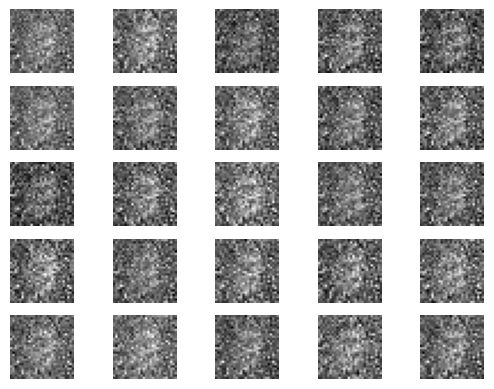

[1/400][0/16] 	Loss_D: 0.9312	Loss_G: -0.7190	D(x): 0.8752	D(G(z)): 0.5493
[2/400][0/16] 	Loss_D: 1.1446	Loss_G: -0.7242	D(x): 0.7668	D(G(z)): 0.5832
[3/400][0/16] 	Loss_D: 1.0615	Loss_G: -0.5180	D(x): 0.7609	D(G(z)): 0.5435
[4/400][0/16] 	Loss_D: 1.1070	Loss_G: -0.4722	D(x): 0.7505	D(G(z)): 0.5574
[5/400][0/16] 	Loss_D: 2.1533	Loss_G: -0.9090	D(x): 0.5787	D(G(z)): 0.7896
[6/400][0/16] 	Loss_D: 0.3390	Loss_G: -0.1427	D(x): 0.8876	D(G(z)): 0.1947
[7/400][0/16] 	Loss_D: 3.1827	Loss_G: -1.7157	D(x): 0.4792	D(G(z)): 0.8964
[8/400][0/16] 	Loss_D: 0.2115	Loss_G: -0.1126	D(x): 0.9215	D(G(z)): 0.1152
[9/400][0/16] 	Loss_D: 1.8358	Loss_G: -0.7234	D(x): 0.7882	D(G(z)): 0.7165
[10/400][0/16] 	Loss_D: 1.1290	Loss_G: -0.5953	D(x): 0.6088	D(G(z)): 0.4584
[11/400][0/16] 	Loss_D: 1.2554	Loss_G: -0.6151	D(x): 0.5883	D(G(z)): 0.5089
[12/400][0/16] 	Loss_D: 0.9491	Loss_G: -0.5460	D(x): 0.5729	D(G(z)): 0.3120
[13/400][0/16] 	Loss_D: 0.9763	Loss_G: -0.3719	D(x): 0.6682	D(G(z)): 0.4293
[14/400][0/16] 	Loss_

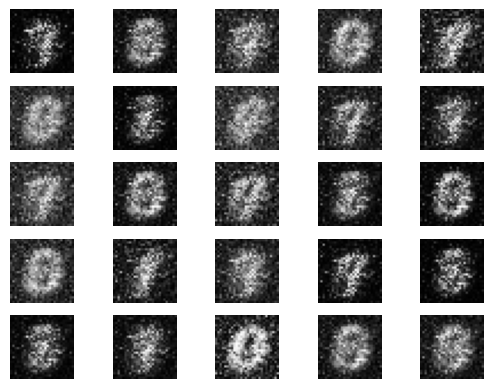

[26/400][0/16] 	Loss_D: 1.1536	Loss_G: -0.2051	D(x): 0.8466	D(G(z)): 0.6031
[27/400][0/16] 	Loss_D: 0.8797	Loss_G: -0.2067	D(x): 0.7897	D(G(z)): 0.4497
[28/400][0/16] 	Loss_D: 1.0249	Loss_G: -0.2363	D(x): 0.7309	D(G(z)): 0.4854
[29/400][0/16] 	Loss_D: 0.9242	Loss_G: -0.7711	D(x): 0.5382	D(G(z)): 0.2006
[30/400][0/16] 	Loss_D: 0.7508	Loss_G: -0.2170	D(x): 0.8375	D(G(z)): 0.4128
[31/400][0/16] 	Loss_D: 0.8787	Loss_G: -0.4014	D(x): 0.6834	D(G(z)): 0.3453
[32/400][0/16] 	Loss_D: 0.6480	Loss_G: -0.3277	D(x): 0.6929	D(G(z)): 0.2072
[33/400][0/16] 	Loss_D: 0.8142	Loss_G: -0.5423	D(x): 0.5709	D(G(z)): 0.1378
[34/400][0/16] 	Loss_D: 1.2157	Loss_G: -0.1825	D(x): 0.9453	D(G(z)): 0.6680
[35/400][0/16] 	Loss_D: 0.9579	Loss_G: -0.4409	D(x): 0.5336	D(G(z)): 0.1671
[36/400][0/16] 	Loss_D: 0.9454	Loss_G: -0.2756	D(x): 0.7205	D(G(z)): 0.3954
[37/400][0/16] 	Loss_D: 0.8454	Loss_G: -0.1600	D(x): 0.7126	D(G(z)): 0.3623
[38/400][0/16] 	Loss_D: 0.8415	Loss_G: -0.2066	D(x): 0.6351	D(G(z)): 0.2735
[39/400][0/1

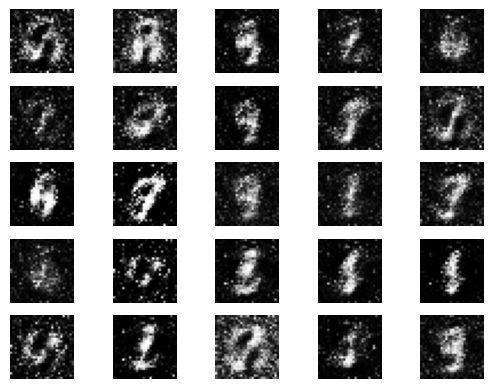

[51/400][0/16] 	Loss_D: 1.1404	Loss_G: -1.1449	D(x): 0.4313	D(G(z)): 0.0412
[52/400][0/16] 	Loss_D: 0.5174	Loss_G: -0.2335	D(x): 0.7516	D(G(z)): 0.1564
[53/400][0/16] 	Loss_D: 0.7725	Loss_G: -0.3365	D(x): 0.5963	D(G(z)): 0.1071
[54/400][0/16] 	Loss_D: 0.7361	Loss_G: -0.6302	D(x): 0.5822	D(G(z)): 0.0550
[55/400][0/16] 	Loss_D: 0.8543	Loss_G: -0.1466	D(x): 0.8890	D(G(z)): 0.4996
[56/400][0/16] 	Loss_D: 0.6249	Loss_G: -0.5417	D(x): 0.6203	D(G(z)): 0.0668
[57/400][0/16] 	Loss_D: 0.9230	Loss_G: -0.4863	D(x): 0.5201	D(G(z)): 0.0795
[58/400][0/16] 	Loss_D: 0.5855	Loss_G: -0.0807	D(x): 0.8682	D(G(z)): 0.3256
[59/400][0/16] 	Loss_D: 0.6416	Loss_G: -0.4887	D(x): 0.6767	D(G(z)): 0.1223
[60/400][0/16] 	Loss_D: 0.8194	Loss_G: -0.2532	D(x): 0.6822	D(G(z)): 0.2504
[61/400][0/16] 	Loss_D: 0.6733	Loss_G: -0.4485	D(x): 0.6726	D(G(z)): 0.1625
[62/400][0/16] 	Loss_D: 0.9682	Loss_G: -0.4331	D(x): 0.5164	D(G(z)): 0.0976
[63/400][0/16] 	Loss_D: 0.7568	Loss_G: -0.0208	D(x): 0.9367	D(G(z)): 0.4482
[64/400][0/1

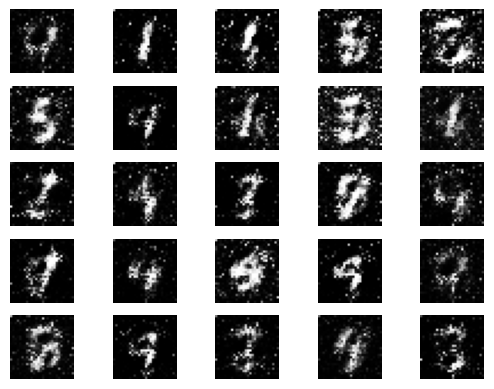

[76/400][0/16] 	Loss_D: 0.7040	Loss_G: -0.4232	D(x): 0.6324	D(G(z)): 0.1441
[77/400][0/16] 	Loss_D: 0.5173	Loss_G: -0.1819	D(x): 0.7910	D(G(z)): 0.2096
[78/400][0/16] 	Loss_D: 0.6383	Loss_G: -0.2505	D(x): 0.7790	D(G(z)): 0.2634
[79/400][0/16] 	Loss_D: 0.7629	Loss_G: -0.2558	D(x): 0.6081	D(G(z)): 0.1240
[80/400][0/16] 	Loss_D: 0.3694	Loss_G: -0.1336	D(x): 0.8239	D(G(z)): 0.1287
[81/400][0/16] 	Loss_D: 0.3597	Loss_G: -0.1466	D(x): 0.8321	D(G(z)): 0.1281
[82/400][0/16] 	Loss_D: 0.8649	Loss_G: -0.6432	D(x): 0.5945	D(G(z)): 0.1359
[83/400][0/16] 	Loss_D: 0.4273	Loss_G: -0.1949	D(x): 0.7920	D(G(z)): 0.1494
[84/400][0/16] 	Loss_D: 0.6886	Loss_G: -0.4856	D(x): 0.6246	D(G(z)): 0.0746
[85/400][0/16] 	Loss_D: 0.4795	Loss_G: -0.1250	D(x): 0.8736	D(G(z)): 0.2544
[86/400][0/16] 	Loss_D: 0.7167	Loss_G: -0.1537	D(x): 0.8177	D(G(z)): 0.3354
[87/400][0/16] 	Loss_D: 0.3406	Loss_G: -0.0924	D(x): 0.8967	D(G(z)): 0.1898
[88/400][0/16] 	Loss_D: 1.1030	Loss_G: -0.0037	D(x): 0.9322	D(G(z)): 0.6062
[89/400][0/1

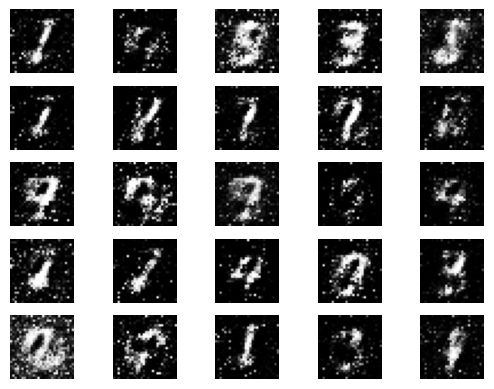

[101/400][0/16] 	Loss_D: 1.1394	Loss_G: -0.1748	D(x): 0.8413	D(G(z)): 0.5667
[102/400][0/16] 	Loss_D: 0.4609	Loss_G: -0.1494	D(x): 0.8689	D(G(z)): 0.2415
[103/400][0/16] 	Loss_D: 0.7874	Loss_G: -0.0982	D(x): 0.9315	D(G(z)): 0.4762
[104/400][0/16] 	Loss_D: 1.5196	Loss_G: -0.0060	D(x): 0.9672	D(G(z)): 0.7436
[105/400][0/16] 	Loss_D: 1.4038	Loss_G: -0.4784	D(x): 0.3576	D(G(z)): 0.0254
[106/400][0/16] 	Loss_D: 0.8210	Loss_G: -0.5507	D(x): 0.5547	D(G(z)): 0.0514
[107/400][0/16] 	Loss_D: 0.4842	Loss_G: -0.1318	D(x): 0.7825	D(G(z)): 0.1697
[108/400][0/16] 	Loss_D: 0.9002	Loss_G: -0.0303	D(x): 0.9226	D(G(z)): 0.5215
[109/400][0/16] 	Loss_D: 0.4673	Loss_G: -0.0651	D(x): 0.8754	D(G(z)): 0.2532
[110/400][0/16] 	Loss_D: 0.8662	Loss_G: -0.0050	D(x): 0.9569	D(G(z)): 0.5181
[111/400][0/16] 	Loss_D: 1.3318	Loss_G: -1.0633	D(x): 0.4004	D(G(z)): 0.0253
[112/400][0/16] 	Loss_D: 0.4919	Loss_G: -0.1453	D(x): 0.8061	D(G(z)): 0.2020
[113/400][0/16] 	Loss_D: 0.4278	Loss_G: -0.2797	D(x): 0.7735	D(G(z)): 0.1092

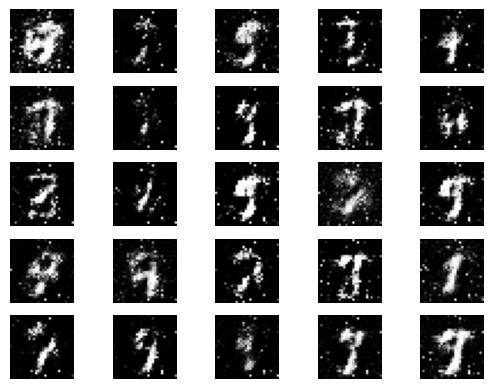

[126/400][0/16] 	Loss_D: 0.7939	Loss_G: -0.6480	D(x): 0.5783	D(G(z)): 0.0134
[127/400][0/16] 	Loss_D: 1.6574	Loss_G: -0.3680	D(x): 0.3578	D(G(z)): 0.0247
[128/400][0/16] 	Loss_D: 0.4291	Loss_G: -0.1216	D(x): 0.8828	D(G(z)): 0.2193
[129/400][0/16] 	Loss_D: 0.5879	Loss_G: -0.2828	D(x): 0.7742	D(G(z)): 0.2007
[130/400][0/16] 	Loss_D: 0.6035	Loss_G: -0.1541	D(x): 0.7694	D(G(z)): 0.2179
[131/400][0/16] 	Loss_D: 0.5375	Loss_G: -0.4613	D(x): 0.7003	D(G(z)): 0.0740
[132/400][0/16] 	Loss_D: 0.4621	Loss_G: -0.1708	D(x): 0.7913	D(G(z)): 0.1498
[133/400][0/16] 	Loss_D: 0.8675	Loss_G: -0.0827	D(x): 0.8762	D(G(z)): 0.4619
[134/400][0/16] 	Loss_D: 0.4614	Loss_G: -0.2316	D(x): 0.7557	D(G(z)): 0.1058
[135/400][0/16] 	Loss_D: 0.5857	Loss_G: -0.0855	D(x): 0.8274	D(G(z)): 0.2723
[136/400][0/16] 	Loss_D: 0.7757	Loss_G: -0.1976	D(x): 0.7687	D(G(z)): 0.3383
[137/400][0/16] 	Loss_D: 0.5950	Loss_G: -0.0631	D(x): 0.9442	D(G(z)): 0.3675
[138/400][0/16] 	Loss_D: 0.7670	Loss_G: -0.0088	D(x): 0.9547	D(G(z)): 0.4662

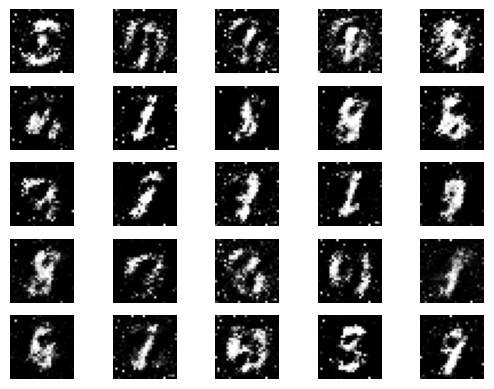

[151/400][0/16] 	Loss_D: 0.5637	Loss_G: -0.3044	D(x): 0.6890	D(G(z)): 0.0573
[152/400][0/16] 	Loss_D: 0.6410	Loss_G: -0.3403	D(x): 0.8585	D(G(z)): 0.3216
[153/400][0/16] 	Loss_D: 0.3699	Loss_G: -0.1570	D(x): 0.8340	D(G(z)): 0.1279
[154/400][0/16] 	Loss_D: 0.5639	Loss_G: -0.3599	D(x): 0.7352	D(G(z)): 0.1015
[155/400][0/16] 	Loss_D: 0.3286	Loss_G: -0.0714	D(x): 0.8977	D(G(z)): 0.1802
[156/400][0/16] 	Loss_D: 0.4910	Loss_G: -0.3398	D(x): 0.7332	D(G(z)): 0.0858
[157/400][0/16] 	Loss_D: 0.4499	Loss_G: -0.1842	D(x): 0.7648	D(G(z)): 0.0742
[158/400][0/16] 	Loss_D: 0.5135	Loss_G: -0.1981	D(x): 0.7743	D(G(z)): 0.1409
[159/400][0/16] 	Loss_D: 0.8652	Loss_G: -0.5337	D(x): 0.5672	D(G(z)): 0.0514
[160/400][0/16] 	Loss_D: 0.4855	Loss_G: -0.1385	D(x): 0.8339	D(G(z)): 0.1889
[161/400][0/16] 	Loss_D: 0.6033	Loss_G: -0.4671	D(x): 0.6672	D(G(z)): 0.0425
[162/400][0/16] 	Loss_D: 0.7766	Loss_G: -0.0365	D(x): 0.9216	D(G(z)): 0.4335
[163/400][0/16] 	Loss_D: 0.4464	Loss_G: -0.4228	D(x): 0.8719	D(G(z)): 0.2285

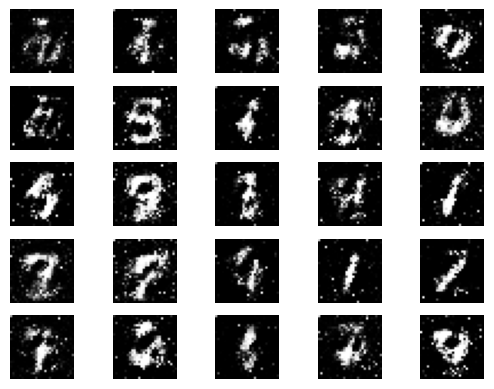

[176/400][0/16] 	Loss_D: 0.3410	Loss_G: -0.1560	D(x): 0.9041	D(G(z)): 0.1771
[177/400][0/16] 	Loss_D: 1.2456	Loss_G: -0.4621	D(x): 0.4801	D(G(z)): 0.0295
[178/400][0/16] 	Loss_D: 0.5235	Loss_G: -0.3527	D(x): 0.7621	D(G(z)): 0.1490
[179/400][0/16] 	Loss_D: 0.5684	Loss_G: -0.0347	D(x): 0.9373	D(G(z)): 0.3306
[180/400][0/16] 	Loss_D: 0.4468	Loss_G: -0.0729	D(x): 0.8809	D(G(z)): 0.2196
[181/400][0/16] 	Loss_D: 1.4343	Loss_G: -0.8281	D(x): 0.3714	D(G(z)): 0.0287
[182/400][0/16] 	Loss_D: 0.4379	Loss_G: -0.0670	D(x): 0.9214	D(G(z)): 0.2710
[183/400][0/16] 	Loss_D: 0.3577	Loss_G: -0.0861	D(x): 0.9040	D(G(z)): 0.2040
[184/400][0/16] 	Loss_D: 3.2426	Loss_G: -0.0244	D(x): 0.9901	D(G(z)): 0.9349
[185/400][0/16] 	Loss_D: 0.8651	Loss_G: -0.4695	D(x): 0.5519	D(G(z)): 0.0745
[186/400][0/16] 	Loss_D: 0.4679	Loss_G: -0.0845	D(x): 0.8762	D(G(z)): 0.2329
[187/400][0/16] 	Loss_D: 0.5794	Loss_G: -0.1050	D(x): 0.9291	D(G(z)): 0.3339
[188/400][0/16] 	Loss_D: 0.5204	Loss_G: -0.2296	D(x): 0.7503	D(G(z)): 0.1298

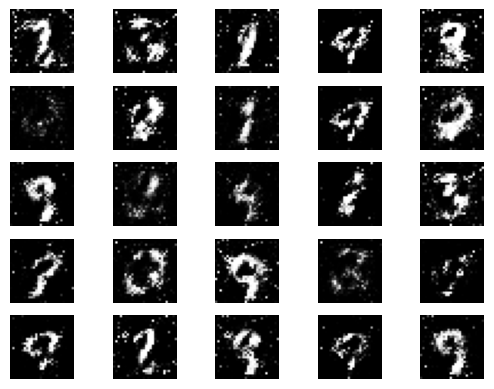

[201/400][0/16] 	Loss_D: 0.7583	Loss_G: -0.9350	D(x): 0.6132	D(G(z)): 0.0212
[202/400][0/16] 	Loss_D: 0.4389	Loss_G: -0.2619	D(x): 0.7862	D(G(z)): 0.0993
[203/400][0/16] 	Loss_D: 0.2903	Loss_G: -0.0645	D(x): 0.8925	D(G(z)): 0.1293
[204/400][0/16] 	Loss_D: 0.3374	Loss_G: -0.1009	D(x): 0.8475	D(G(z)): 0.0838
[205/400][0/16] 	Loss_D: 0.5989	Loss_G: -0.0675	D(x): 0.9194	D(G(z)): 0.3417
[206/400][0/16] 	Loss_D: 0.8191	Loss_G: -0.0541	D(x): 0.9516	D(G(z)): 0.4725
[207/400][0/16] 	Loss_D: 0.3323	Loss_G: -0.1374	D(x): 0.8598	D(G(z)): 0.1334
[208/400][0/16] 	Loss_D: 0.4551	Loss_G: -0.3320	D(x): 0.8207	D(G(z)): 0.1581
[209/400][0/16] 	Loss_D: 0.3743	Loss_G: -0.3311	D(x): 0.8295	D(G(z)): 0.1030
[210/400][0/16] 	Loss_D: 1.0742	Loss_G: -0.5568	D(x): 0.5226	D(G(z)): 0.0186
[211/400][0/16] 	Loss_D: 0.9545	Loss_G: -0.4599	D(x): 0.5689	D(G(z)): 0.0458
[212/400][0/16] 	Loss_D: 0.3815	Loss_G: -0.0568	D(x): 0.9072	D(G(z)): 0.2131
[213/400][0/16] 	Loss_D: 0.4832	Loss_G: -0.2877	D(x): 0.7330	D(G(z)): 0.0444

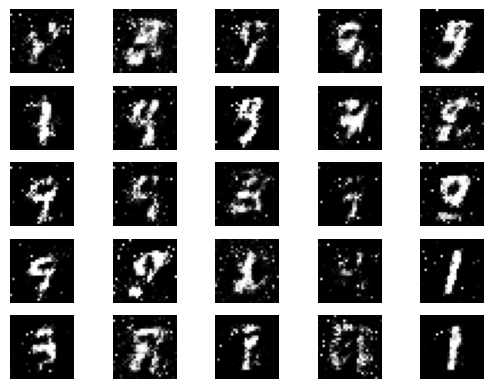

[226/400][0/16] 	Loss_D: 0.3166	Loss_G: -0.1067	D(x): 0.8170	D(G(z)): 0.0483
[227/400][0/16] 	Loss_D: 0.6211	Loss_G: -0.0189	D(x): 0.9694	D(G(z)): 0.3804
[228/400][0/16] 	Loss_D: 0.3383	Loss_G: -0.1753	D(x): 0.8269	D(G(z)): 0.0811
[229/400][0/16] 	Loss_D: 0.3264	Loss_G: -0.1094	D(x): 0.8952	D(G(z)): 0.1606
[230/400][0/16] 	Loss_D: 0.5071	Loss_G: -0.2546	D(x): 0.7704	D(G(z)): 0.1223
[231/400][0/16] 	Loss_D: 0.4822	Loss_G: -0.0155	D(x): 0.9700	D(G(z)): 0.3199
[232/400][0/16] 	Loss_D: 0.6144	Loss_G: -0.3802	D(x): 0.7154	D(G(z)): 0.0496
[233/400][0/16] 	Loss_D: 0.3363	Loss_G: -0.1138	D(x): 0.8510	D(G(z)): 0.1143
[234/400][0/16] 	Loss_D: 0.5868	Loss_G: -0.3171	D(x): 0.6943	D(G(z)): 0.0514
[235/400][0/16] 	Loss_D: 0.3339	Loss_G: -0.0925	D(x): 0.8306	D(G(z)): 0.1016
[236/400][0/16] 	Loss_D: 0.4127	Loss_G: -0.1114	D(x): 0.8925	D(G(z)): 0.1955
[237/400][0/16] 	Loss_D: 0.3281	Loss_G: -0.2250	D(x): 0.8671	D(G(z)): 0.1393
[238/400][0/16] 	Loss_D: 0.3606	Loss_G: -0.1689	D(x): 0.8061	D(G(z)): 0.0773

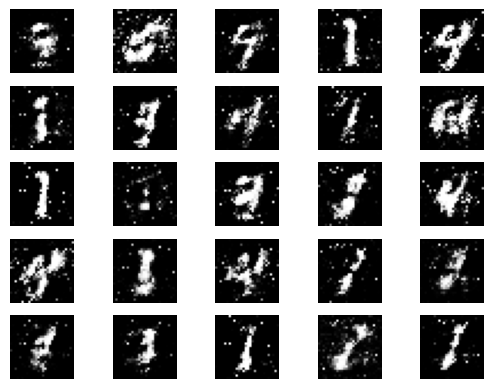

[251/400][0/16] 	Loss_D: 0.6946	Loss_G: -0.0198	D(x): 0.9287	D(G(z)): 0.3883
[252/400][0/16] 	Loss_D: 0.3828	Loss_G: -0.0824	D(x): 0.8919	D(G(z)): 0.2051
[253/400][0/16] 	Loss_D: 0.5371	Loss_G: -0.1980	D(x): 0.7282	D(G(z)): 0.0555
[254/400][0/16] 	Loss_D: 0.3604	Loss_G: -0.2359	D(x): 0.8070	D(G(z)): 0.0758
[255/400][0/16] 	Loss_D: 1.9288	Loss_G: -1.9492	D(x): 0.3201	D(G(z)): 0.0176
[256/400][0/16] 	Loss_D: 0.4252	Loss_G: -0.1372	D(x): 0.8840	D(G(z)): 0.2080
[257/400][0/16] 	Loss_D: 0.3257	Loss_G: -0.0966	D(x): 0.8233	D(G(z)): 0.0682
[258/400][0/16] 	Loss_D: 0.3179	Loss_G: -0.0967	D(x): 0.8844	D(G(z)): 0.1506
[259/400][0/16] 	Loss_D: 1.0162	Loss_G: -0.0130	D(x): 0.9609	D(G(z)): 0.5563
[260/400][0/16] 	Loss_D: 0.4239	Loss_G: -0.1327	D(x): 0.8660	D(G(z)): 0.1832
[261/400][0/16] 	Loss_D: 0.5354	Loss_G: -0.3040	D(x): 0.7645	D(G(z)): 0.1554
[262/400][0/16] 	Loss_D: 0.4002	Loss_G: -0.1829	D(x): 0.8281	D(G(z)): 0.1463
[263/400][0/16] 	Loss_D: 0.7169	Loss_G: -0.0520	D(x): 0.8968	D(G(z)): 0.3846

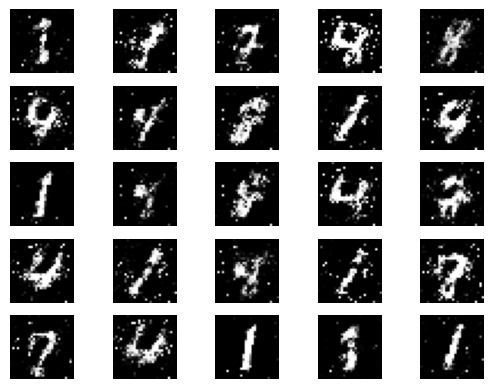

[276/400][0/16] 	Loss_D: 0.3707	Loss_G: -0.1444	D(x): 0.8091	D(G(z)): 0.0768
[277/400][0/16] 	Loss_D: 0.4756	Loss_G: -0.1538	D(x): 0.8546	D(G(z)): 0.2028
[278/400][0/16] 	Loss_D: 0.7423	Loss_G: -0.3918	D(x): 0.6349	D(G(z)): 0.0668
[279/400][0/16] 	Loss_D: 0.6332	Loss_G: -0.5555	D(x): 0.6885	D(G(z)): 0.0730
[280/400][0/16] 	Loss_D: 0.6314	Loss_G: -0.5587	D(x): 0.6918	D(G(z)): 0.1081
[281/400][0/16] 	Loss_D: 0.4514	Loss_G: -0.0919	D(x): 0.8683	D(G(z)): 0.2172
[282/400][0/16] 	Loss_D: 0.4252	Loss_G: -0.1271	D(x): 0.8915	D(G(z)): 0.2140
[283/400][0/16] 	Loss_D: 0.5499	Loss_G: -0.3052	D(x): 0.7247	D(G(z)): 0.0679
[284/400][0/16] 	Loss_D: 0.4091	Loss_G: -0.0450	D(x): 0.9368	D(G(z)): 0.2527
[285/400][0/16] 	Loss_D: 0.6628	Loss_G: -0.0272	D(x): 0.9532	D(G(z)): 0.3837
[286/400][0/16] 	Loss_D: 0.7492	Loss_G: -0.4456	D(x): 0.5857	D(G(z)): 0.0320
[287/400][0/16] 	Loss_D: 0.3868	Loss_G: -0.0450	D(x): 0.9516	D(G(z)): 0.2548
[288/400][0/16] 	Loss_D: 0.3211	Loss_G: -0.1893	D(x): 0.8264	D(G(z)): 0.0586

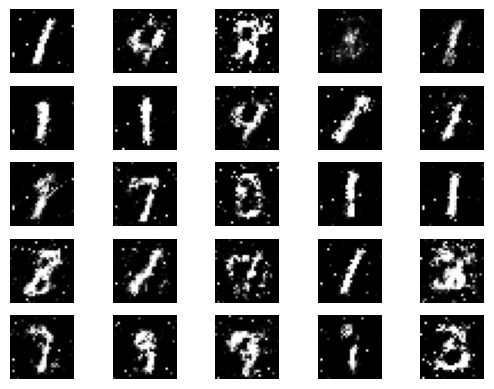

[301/400][0/16] 	Loss_D: 0.4169	Loss_G: -0.1002	D(x): 0.8802	D(G(z)): 0.2072
[302/400][0/16] 	Loss_D: 0.3780	Loss_G: -0.2075	D(x): 0.7909	D(G(z)): 0.0684
[303/400][0/16] 	Loss_D: 0.3527	Loss_G: -0.0571	D(x): 0.9347	D(G(z)): 0.2160
[304/400][0/16] 	Loss_D: 0.3116	Loss_G: -0.0678	D(x): 0.9157	D(G(z)): 0.1800
[305/400][0/16] 	Loss_D: 0.4696	Loss_G: -0.0484	D(x): 0.9215	D(G(z)): 0.2776
[306/400][0/16] 	Loss_D: 0.3980	Loss_G: -0.2514	D(x): 0.8026	D(G(z)): 0.1151
[307/400][0/16] 	Loss_D: 0.2951	Loss_G: -0.1097	D(x): 0.8472	D(G(z)): 0.0971
[308/400][0/16] 	Loss_D: 0.7614	Loss_G: -0.4695	D(x): 0.6178	D(G(z)): 0.0332
[309/400][0/16] 	Loss_D: 0.3195	Loss_G: -0.1376	D(x): 0.8755	D(G(z)): 0.1373
[310/400][0/16] 	Loss_D: 0.4649	Loss_G: -0.0397	D(x): 0.9529	D(G(z)): 0.2923
[311/400][0/16] 	Loss_D: 1.2451	Loss_G: -0.0075	D(x): 0.9662	D(G(z)): 0.6213
[312/400][0/16] 	Loss_D: 0.4962	Loss_G: -0.3433	D(x): 0.7673	D(G(z)): 0.1368
[313/400][0/16] 	Loss_D: 0.3817	Loss_G: -0.1186	D(x): 0.8280	D(G(z)): 0.1224

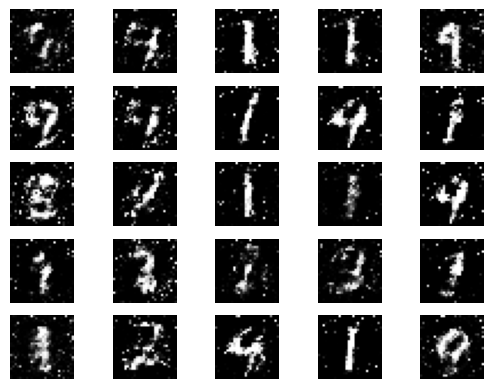

[326/400][0/16] 	Loss_D: 0.5279	Loss_G: -0.0868	D(x): 0.9307	D(G(z)): 0.3213
[327/400][0/16] 	Loss_D: 0.5212	Loss_G: -0.2053	D(x): 0.7602	D(G(z)): 0.1150
[328/400][0/16] 	Loss_D: 0.3834	Loss_G: -0.1472	D(x): 0.8725	D(G(z)): 0.1627
[329/400][0/16] 	Loss_D: 0.3653	Loss_G: -0.2570	D(x): 0.8398	D(G(z)): 0.1000
[330/400][0/16] 	Loss_D: 0.4422	Loss_G: -0.0712	D(x): 0.9159	D(G(z)): 0.2348
[331/400][0/16] 	Loss_D: 0.4975	Loss_G: -0.0874	D(x): 0.8716	D(G(z)): 0.2401
[332/400][0/16] 	Loss_D: 0.6743	Loss_G: -0.5247	D(x): 0.6771	D(G(z)): 0.0764
[333/400][0/16] 	Loss_D: 0.5291	Loss_G: -0.2460	D(x): 0.7561	D(G(z)): 0.1316
[334/400][0/16] 	Loss_D: 0.5970	Loss_G: -0.3159	D(x): 0.6793	D(G(z)): 0.0461
[335/400][0/16] 	Loss_D: 0.2582	Loss_G: -0.1092	D(x): 0.8890	D(G(z)): 0.1081
[336/400][0/16] 	Loss_D: 0.6357	Loss_G: -0.8606	D(x): 0.6302	D(G(z)): 0.0253
[337/400][0/16] 	Loss_D: 0.5286	Loss_G: -0.0368	D(x): 0.9416	D(G(z)): 0.3251
[338/400][0/16] 	Loss_D: 0.4568	Loss_G: -0.2701	D(x): 0.7766	D(G(z)): 0.0951

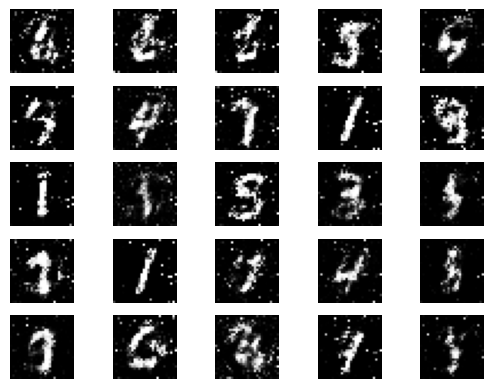

[351/400][0/16] 	Loss_D: 0.3837	Loss_G: -0.1996	D(x): 0.7869	D(G(z)): 0.0830
[352/400][0/16] 	Loss_D: 0.6915	Loss_G: -0.0454	D(x): 0.9208	D(G(z)): 0.3848
[353/400][0/16] 	Loss_D: 0.4420	Loss_G: -0.2732	D(x): 0.7892	D(G(z)): 0.1238
[354/400][0/16] 	Loss_D: 1.0292	Loss_G: -1.2151	D(x): 0.4910	D(G(z)): 0.0280
[355/400][0/16] 	Loss_D: 0.3322	Loss_G: -0.1470	D(x): 0.8524	D(G(z)): 0.1202
[356/400][0/16] 	Loss_D: 0.5652	Loss_G: -0.4298	D(x): 0.7119	D(G(z)): 0.0849
[357/400][0/16] 	Loss_D: 1.6661	Loss_G: -0.7615	D(x): 0.3507	D(G(z)): 0.0203
[358/400][0/16] 	Loss_D: 0.4127	Loss_G: -0.1236	D(x): 0.8487	D(G(z)): 0.1737
[359/400][0/16] 	Loss_D: 0.4324	Loss_G: -0.2732	D(x): 0.8275	D(G(z)): 0.1682
[360/400][0/16] 	Loss_D: 0.5378	Loss_G: -0.0491	D(x): 0.8766	D(G(z)): 0.2820
[361/400][0/16] 	Loss_D: 0.5027	Loss_G: -0.3297	D(x): 0.7429	D(G(z)): 0.1247
[362/400][0/16] 	Loss_D: 0.5258	Loss_G: -0.1055	D(x): 0.8678	D(G(z)): 0.2414
[363/400][0/16] 	Loss_D: 0.4466	Loss_G: -0.0662	D(x): 0.8622	D(G(z)): 0.1965

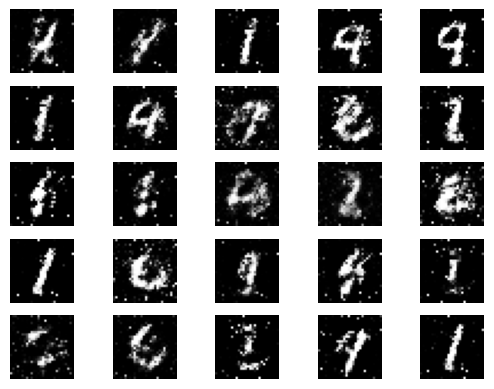

[376/400][0/16] 	Loss_D: 0.4399	Loss_G: -0.0674	D(x): 0.9208	D(G(z)): 0.2342
[377/400][0/16] 	Loss_D: 0.3973	Loss_G: -0.2425	D(x): 0.7803	D(G(z)): 0.0663
[378/400][0/16] 	Loss_D: 0.6364	Loss_G: -0.3133	D(x): 0.8328	D(G(z)): 0.2741
[379/400][0/16] 	Loss_D: 0.4072	Loss_G: -0.2103	D(x): 0.7886	D(G(z)): 0.0952
[380/400][0/16] 	Loss_D: 0.4112	Loss_G: -0.1324	D(x): 0.8187	D(G(z)): 0.1355
[381/400][0/16] 	Loss_D: 0.7045	Loss_G: -0.4205	D(x): 0.6387	D(G(z)): 0.0477
[382/400][0/16] 	Loss_D: 0.5112	Loss_G: -0.3193	D(x): 0.7399	D(G(z)): 0.1158
[383/400][0/16] 	Loss_D: 0.4661	Loss_G: -0.2532	D(x): 0.8641	D(G(z)): 0.2181
[384/400][0/16] 	Loss_D: 0.4581	Loss_G: -0.1166	D(x): 0.8874	D(G(z)): 0.2457
[385/400][0/16] 	Loss_D: 0.6784	Loss_G: -0.4589	D(x): 0.6268	D(G(z)): 0.0612
[386/400][0/16] 	Loss_D: 1.6024	Loss_G: -0.9164	D(x): 0.3458	D(G(z)): 0.0200
[387/400][0/16] 	Loss_D: 0.3672	Loss_G: -0.1542	D(x): 0.8297	D(G(z)): 0.1167
[388/400][0/16] 	Loss_D: 1.1707	Loss_G: -0.0058	D(x): 0.9688	D(G(z)): 0.5952

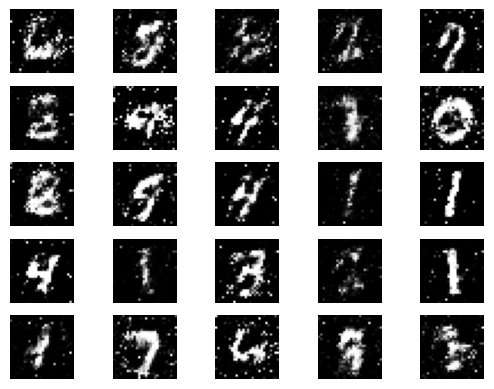

In [152]:
# Training Loop

# disc_model.to(device)
# gen_model.to(device)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0,n_iters_inner):
      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels 
      true_imgs = data[0] #accessing the tensors inside the list
      # true_imgs.shape = ([number_of_imgs, channels, img_rows, img_cols])
      true_labels = torch.ones((true_imgs.shape[0],1), dtype=torch.float)
      # put true data through discriminator
      d_output_true = disc_model(true_imgs)
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true, true_labels)
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise = np.random.normal(0, 1, (true_imgs.shape[0], z_dim))
      # Generate batch of fake images
      fake_imgs = gen_model.forward(torch.from_numpy(z_latent_noise).float())
      fake_labels = torch.zeros((true_imgs.shape[0],1), dtype=torch.float)
      # put fake data through discriminator
      disc_output_fake = disc_model(fake_imgs)
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake, fake_labels)
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward(retain_graph=True )
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake =  disc_model(fake_imgs)
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake)
    # backpropagation for generator
    g_loss.backward(retain_graph=True)
    #D_G_z2 = output.mean().item()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())

  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

# end samples
sample_images(gen_model,z_dim, rand_seed=30)


In [19]:
# saving the models to disk in order to use them later
models_path = 'models/'
torch.save(disc_model.state_dict(), models_path + 'disc_model.pt')
torch.save(gen_model.state_dict(), models_path + 'gen_model.pt')

In [20]:
# loading the models from disk
gen_model.load_state_dict(torch.load(models_path + 'gen_model.pt'))
disc_model.load_state_dict(torch.load(models_path + 'disc_model.pt'))

<All keys matched successfully>

## 6/ Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points. 

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here. 

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

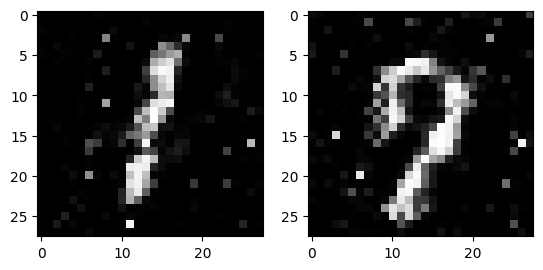

In [162]:
# first image
random_seed = 100 # change this seed to find the best image
torch.manual_seed(random_seed)
z_0 = np.random.normal(0, 1, (1, z_dim))
x_0 = gen_model.forward(torch.from_numpy(z_0).float()) 

random_seed = 70 # change this seed to find the best image
torch.manual_seed(random_seed)
z_1 = np.random.normal(0, 1, (1, z_dim))
x_1 = gen_model.forward(torch.from_numpy(z_1).float())

# display images
# FILL IN HERE
plt.figure()
plt.subplot(1,2,1)
plt.imshow(x_0.detach().numpy().reshape(28,28), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(x_1.detach().numpy().reshape(28,28), cmap='gray')
plt.show()

Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

In [163]:
n_interpolation = 20
# FILL IN HERE
z_interpolation = np.zeros((n_interpolation, z_dim))
for i in range(n_interpolation):
    z_interpolation[i,:] = z_0 + i/(n_interpolation-1)*(z_1-z_0)

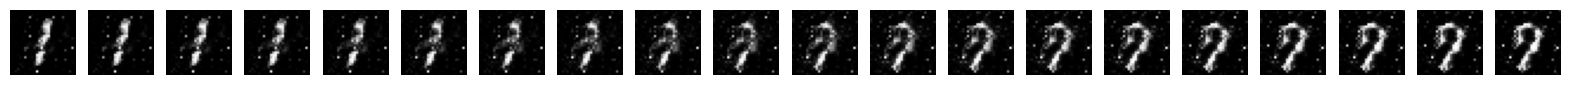

In [164]:
# display results

fig, axs = plt.subplots(1, n_interpolation,figsize=(20,20))
imgs = []
for i in range(n_interpolation):
  #black and white images
  im = gen_model.forward(torch.from_numpy(z_interpolation[i,:]).float())
  im = im.detach().numpy().reshape(28,28)
  axs[i].imshow(im, cmap='gray')
  axs[i].axis('off')
plt.show()

What do you think of the quality of the output images ?

__Answer__: The quality of the output images is not very good. Some digits are not very clear, the images are blurry and there are some artifacts. This maybe can be explained due to the fact that the generator is not trained enough. Although this fact, we can recognize some digits.
About the interpolation, we can see that the digits are changing smoothly from one to another and there are some interval where the digits are not very clear.

## 7/ Evaluation of navigation

Now, we are going to evaluate this navigation. We will investigate two properties:

- 1/ We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;
- 2/ We are going to see whether the confidence of a classification network in different regions varies much. In other words, when we navigate in the latent space, do we go into zones which do not correspond to any number (according to the classification network) ? 

For this, we will first need a classification network. Take the code from the last lab work on variational autoencoders, and extract the section where we trained a classifier on mnist. Here is the architecture we used:

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

In [21]:
# define mnist classifier model, loss function, optimiser and the function 'get_accuracy'

learning_rate = 0.01
n_epochs = 20
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

mnist_classification_model = torch.nn.Sequential(
    nn.Conv2d(n_h_0, n_h_1, kernel_size=kernel_size, stride=(1, 1), padding="same"),
    nn.ReLU(),
    nn.Conv2d(n_h_1, n_h_2, kernel_size=kernel_size, stride=(1, 1), padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(pool_size, stride=(2, 2)),
    nn.Flatten(),
    nn.Linear(14*14*n_h_2, nb_classes),
)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_classification_model.parameters(), lr=learning_rate)

In [23]:
def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

In [24]:
# training the classifier

train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):
    # set the gradients back to 0
    optimizer.zero_grad()
    predict=mnist_classification_model(imgs)
    # apply loss function
    loss=criterion(predict,labels)
    acc = get_accuracy(torch.argmax(predict,dim=1),labels)
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch,train_loss/imgs.shape[0],acc))

# FILL IN HERE

Epoch:0 Train Loss:0.0146 Accuracy:0.8500
Epoch:1 Train Loss:0.0108 Accuracy:0.8750
Epoch:2 Train Loss:0.0064 Accuracy:0.9000
Epoch:3 Train Loss:0.0044 Accuracy:0.9250
Epoch:4 Train Loss:0.0043 Accuracy:0.9250
Epoch:5 Train Loss:0.0006 Accuracy:1.0000
Epoch:6 Train Loss:0.0001 Accuracy:1.0000
Epoch:7 Train Loss:0.0001 Accuracy:1.0000
Epoch:8 Train Loss:0.0013 Accuracy:0.9750
Epoch:9 Train Loss:0.0003 Accuracy:1.0000
Epoch:10 Train Loss:0.0000 Accuracy:1.0000
Epoch:11 Train Loss:0.0001 Accuracy:1.0000
Epoch:12 Train Loss:0.0000 Accuracy:1.0000
Epoch:13 Train Loss:0.0000 Accuracy:1.0000
Epoch:14 Train Loss:0.0000 Accuracy:1.0000
Epoch:15 Train Loss:0.0000 Accuracy:1.0000
Epoch:16 Train Loss:0.0000 Accuracy:1.0000
Epoch:17 Train Loss:0.0000 Accuracy:1.0000
Epoch:18 Train Loss:0.0000 Accuracy:1.0000
Epoch:19 Train Loss:0.0000 Accuracy:1.0000


In [139]:
# saving the model to disk in order to use it later
torch.save(mnist_classification_model.state_dict(), models_path + 'mnist_classification_model.pt')

In [170]:
# loading the model from disk
mnist_classification_model.load_state_dict(torch.load(models_path + 'mnist_classification_model.pt'))

<All keys matched successfully>

### 7.1/ Evaluation of navigation part 1

Now, create a function which returns the classification returned by this network on mnist images. Remember, the classification model above returns the values __before__ the softmax is applied, and here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).


In [171]:
def predict_mnist_class(imgs_in,classification_model):
  output_classes = torch.argmax(F.softmax(classification_model(imgs_in)),dim=1)
  return(output_classes)

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

In [172]:
imgs = gen_model.forward(torch.from_numpy(z_interpolation).float()).view(-1,1,28,28)
z_classes = predict_mnist_class(imgs, mnist_classification_model) 
print(z_classes)

tensor([1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])


/tmp/ipykernel_8273/2201188690.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_classes = torch.argmax(F.softmax(classification_model(imgs_in)),dim=1)


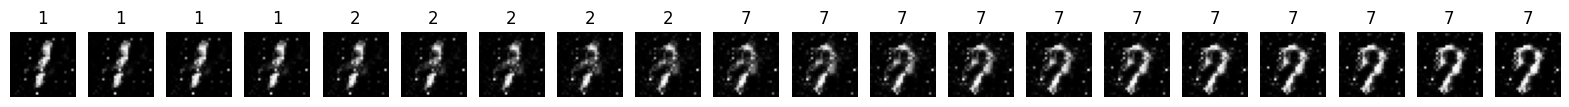

In [173]:
# display results

fig, axs = plt.subplots(1, n_interpolation,figsize=(20,20))
for i in range(n_interpolation):
  #black and white images
  axs[i].set_title(f'{z_classes[i]}')
  axs[i].imshow(imgs.view(-1,28,28,1).detach().numpy()[i], cmap='gray')
  axs[i].axis('off')
plt.show()

__Answer__

On the first moment I interpreted the last image (left to right) as a 9 while the classification model classified it as 7, which in my opinion is one of the possible interpretations. There are an interval of images where the classification model classifies them as 2, which is not the case of the first image and the last one. So, the latent space navigation traverses regions with classes other than those of $z_0$ and $z_1$.

### 7.2/ Evaluation of navigation part 2

Even though the network may predict coherent image classes during the navigation, it may predict these classes with different confidences. Ideally, we would like the latent space to contain codes which produce images of constant quality. Therefore, as mentioned above, we want to check these prediction confidences during navigation on our GAN.

Carry this out now. First of all, define a function which, instead of funding the output *classes* of the interpolations, find the *probability* of the most likely class (the same operation as in the lab on variational autoencoders).


In [174]:
def predict_mnist_confidence(imgs_in,classification_model):
  output_classes = torch.max(F.softmax(classification_model(imgs_in), dim=1), dim=1)
  return(output_classes)

Using this function, carry out the second evaluation on the images generated by interpolated latent codes.

In [175]:
z_confidence = predict_mnist_confidence(imgs, mnist_classification_model)
print(z_confidence)

torch.return_types.max(
values=tensor([0.9985, 0.9951, 0.9738, 0.8021, 0.6619, 0.8075, 0.7569, 0.6623, 0.4802,
        0.4902, 0.6457, 0.7962, 0.8799, 0.9502, 0.9815, 0.9918, 0.9963, 0.9984,
        0.9992, 0.9995], grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]))


Does the confidence change greatly during interpolation ? Does the navigation go through zones where the classification is not confident ? Why do you think this is ? (think about the form/shape of the latent space).

__Answer__

Yes, there are zones where the confidence change greatly during interpolation changing from 0.99 to 0.48. The navigation goes through zones where the classification is not confident, this could be explained due to the fact that the latent space is not necessarily linear while the interpolation is. So, the interpolation is not the best way to navigate in the latent space.

# __Optional__ : Training on CIFAR

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [ ]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

Now, we can redefine the hyper-parameters of the model (change if you wish)

In [68]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 

In [ ]:
# GAN implementation

# FILL IN HERE

Now, carry out the training (use code above)

In [ ]:
# training code

# FILL IN HERE